In [12]:
import pandas as pd
import numpy as np # Import numpy for NaT
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os
print("--- Starting Full Data Processing Pipeline ---")

# --- 1. Load Historical Trader Data ---
try:
    historical_df = pd.read_csv(r'C:\Users\potta\Desktop\projects\trader\data\historical_data.csv')
    print("\nHistorical Data Loaded Successfully!")
    print("\n--- Initial Historical Data Info ---")
    historical_df.info()
    print("\n--- Initial Historical Data Head ---")
    print(historical_df.head())
except FileNotFoundError:
    print("CRITICAL ERROR: historical_data.csv not found. Please ensure it's in the same directory as this notebook.")
    raise # Stop execution if file isn't found
except Exception as e:
    print(f"CRITICAL ERROR loading historical data: {e}")
    raise

# --- 2. Load Bitcoin Market Sentiment Data (Fear/Greed Index) ---
try:
    fear_greed_df = pd.read_csv(r'C:\Users\potta\Desktop\projects\trader\data\fear_greed_index.csv')
    print("\nFear/Greed Index Loaded Successfully!")
    print("\n--- Initial Fear/Greed Index Info ---")
    fear_greed_df.info()
    print("\n--- Initial Fear/Greed Index Head ---")
    print(fear_greed_df.head())
except FileNotFoundError:
    print("CRITICAL ERROR: fear_greed_index.csv not found. Please ensure it's in the same directory as this notebook.")
    raise
except Exception as e:
    print(f"CRITICAL ERROR loading fear/greed data: {e}")
    raise

print("\n" + "="*50 + "\n") # Separator

# --- Derive Closed PnL if missing ---
if 'Closed PnL' not in historical_df.columns:
    print("WARNING: 'Closed PnL' column not found. Attempting to derive it...")
    if all(col in historical_df.columns for col in ['Exit Price', 'Entry Price', 'Size USD']):
        # Adjust this formula as per your dataset's logic
        historical_df['Closed PnL'] = (historical_df['Exit Price'] - historical_df['Entry Price']) * historical_df['Size USD']
        print("'Closed PnL' successfully derived.")
    else:
        raise ValueError("Required columns to derive 'Closed PnL' are missing. Cannot proceed.")

# --- 3. Clean Historical Data: Convert 'Timestamp IST' and rename ---
print("--- Cleaning Historical Data (Timestamp Conversion) ---")
print("Attempting to convert 'Timestamp IST' to datetime objects in historical_df...")
try:
    # Use to_datetime with the specified format and coercing errors
    # If the format doesn't match for some rows, they will become NaT
    historical_df['Timestamp'] = pd.to_datetime(historical_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')

    # Drop the original 'Timestamp IST' column after conversion
    historical_df.drop(columns=['Timestamp IST'], inplace=True)

    # Check for NaT values after conversion and handle them
    nat_count = historical_df['Timestamp'].isnull().sum()
    if nat_count > 0:
        print(f"Warning: Found {nat_count} NaT values in 'Timestamp' column after conversion. These rows will be dropped.")
        historical_df.dropna(subset=['Timestamp'], inplace=True) # Drop rows with unparseable timestamps
    print("Conversion complete.")
except Exception as e:
    print(f"CRITICAL ERROR converting 'Timestamp IST': {e}. Stopping pipeline.")
    raise # Stop execution if conversion fails

print("\n--- Updated Historical Data Info (after timestamp conversion & rename) ---")
historical_df.info()
print("\n--- First 5 Timestamps in Historical Data (after conversion) ---")
print(historical_df['Timestamp'].head())
print("\n--- Last 5 Timestamps in Historical Data (after conversion) ---")
print(historical_df['Timestamp'].tail())
print(f"\nNumber of duplicate rows in historical_df: {historical_df.duplicated().sum()}")

print("\n" + "="*50 + "\n") # Separator

# --- 4. Clean Fear/Greed Index Data: Convert 'timestamp' and 'date' ---
print("--- Cleaning Fear/Greed Index Data (Timestamp Conversion) ---")
print("Converting 'timestamp' and 'date' in fear_greed_df...")
try:
    # Convert 'timestamp' (Unix timestamp) to datetime, coercing errors
    fear_greed_df['timestamp_dt'] = pd.to_datetime(fear_greed_df['timestamp'], unit='s', errors='coerce')
    # Convert 'date' column to datetime, coercing errors
    fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'], errors='coerce')

    # Check for NaT values and drop them
    nat_count_ts = fear_greed_df['timestamp_dt'].isnull().sum()
    nat_count_date = fear_greed_df['date'].isnull().sum()
    if nat_count_ts > 0 or nat_count_date > 0:
        print(f"Warning: Found {nat_count_ts} NaT in 'timestamp_dt' and {nat_count_date} in 'date'. Dropping rows with NaT.")
        fear_greed_df.dropna(subset=['timestamp_dt', 'date'], inplace=True)
    print("Conversion complete.")
except Exception as e:
    print(f"CRITICAL ERROR converting fear/greed timestamps: {e}. Stopping pipeline.")
    raise

print("\n--- Updated Fear/Greed Index Info ---")
fear_greed_df.info()
print("\n--- First 5 Timestamps and Dates in Fear/Greed Index ---")
print(fear_greed_df[['timestamp_dt', 'date']].head())
print("\n--- Last 5 Timestamps and Dates in Fear/Greed Index ---")
print(fear_greed_df[['timestamp_dt', 'date']].tail())
print(f"\nNumber of duplicate rows in fear_greed_df: {fear_greed_df.duplicated().sum()}")
print(f"\nFear/Greed Data Date Range: {fear_greed_df['date'].min()} to {fear_greed_df['date'].max()}")

print("\n" + "="*50 + "\n") # Separator

# --- 5. Aggregate Historical Trader Data to Daily PnL ---
print("--- Aggregating Historical Trader Data to Daily PnL ---")

# Explicitly check the dtype one more time just before this section
print(f"DEBUG: historical_df['Timestamp'] dtype BEFORE aggregation: {historical_df['Timestamp'].dtype}")

if not pd.api.types.is_datetime64_any_dtype(historical_df['Timestamp']):
    print("CRITICAL ERROR: 'Timestamp' column in historical_df is NOT datetime after all cleaning attempts. Cannot aggregate.")
    print(f"Current dtype: {historical_df['Timestamp'].dtype}")
    print("First few values of 'Timestamp':")
    print(historical_df['Timestamp'].head())
    raise # Stop execution
else:
    # Extract the date part from the 'Timestamp' column for daily aggregation
    historical_df['trade_date'] = historical_df['Timestamp'].dt.date
    historical_df['trade_date'] = pd.to_datetime(historical_df['trade_date']) # Convert back to datetime object (without time) for merging

    # Calculate daily PnL for each account
    daily_pnl = historical_df.groupby(['Account', 'trade_date'])['Closed PnL'].sum().reset_index()
    daily_pnl.rename(columns={'Closed PnL': 'Daily_Net_PnL'}, inplace=True)

    print("\n--- Daily PnL Data Info (per Account) ---")
    daily_pnl.info()
    print("\n--- First 5 Rows of Daily PnL Data (per Account) ---")
    print(daily_pnl.head())

    # Calculate overall market daily PnL (sum of all accounts)
    market_daily_pnl = daily_pnl.groupby('trade_date')['Daily_Net_PnL'].sum().reset_index()
    market_daily_pnl.rename(columns={'Daily_Net_PnL': 'Market_Daily_PnL'}, inplace=True)
    print("\n--- Market Daily PnL Data Info (Overall) ---")
    market_daily_pnl.info()
    print("\n--- First 5 Rows of Market Daily PnL Data (Overall) ---")
    print(market_daily_pnl.head())
    print("\n--- Last 5 Rows of Market Daily PnL Data (Overall) ---")
    print(market_daily_pnl.tail())

    # Check date range for market daily pnl
    print(f"\nMarket Daily PnL Date Range: {market_daily_pnl['trade_date'].min()} to {market_daily_pnl['trade_date'].max()}")

print("\n--- All initial processing steps completed. ---")

--- Starting Full Data Processing Pipeline ---

Historical Data Loaded Successfully!

--- Initial Historical Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float6

In [13]:
print("\n" + "="*50 + "\n") # Separator
print("--- Merging Datasets ---")

# Ensure the date columns have the same name and are datetime for merging
# market_daily_pnl has 'trade_date'
# fear_greed_df has 'date'
# Let's align them by renaming one or creating a new common column
fear_greed_df['common_date'] = fear_greed_df['date'] # Create a common date column in fear_greed_df
market_daily_pnl['common_date'] = market_daily_pnl['trade_date'] # Create a common date column in market_daily_pnl

# Perform the merge. We'll use a 'left' merge to keep all dates from the market PnL data,
# and bring in corresponding fear/greed data.
# It's important to decide which one is the "primary" dataset.
# Given we are analyzing trader performance against sentiment, we'll keep all trader dates.
merged_df = pd.merge(market_daily_pnl, fear_greed_df[['common_date', 'value', 'classification']],
                     on='common_date',
                     how='left')

print("\n--- Merged Data Info ---")
merged_df.info()

print("\n--- First 10 Rows of Merged Data ---")
print(merged_df.head(10))

print("\n--- Last 10 Rows of Merged Data ---")
print(merged_df.tail(10))

# Check for NaN values in the merged 'value' and 'classification' columns
# These NaNs would indicate dates from market_daily_pnl that do not have corresponding fear/greed data
print(f"\nNaNs in 'value' after merge: {merged_df['value'].isnull().sum()}")
print(f"NaNs in 'classification' after merge: {merged_df['classification'].isnull().sum()}")

# Fill missing sentiment classification with 'Neutral'
merged_df['classification'].fillna('Neutral', inplace=True)

# Display date range of the merged data
print(f"\nMerged Data Date Range: {merged_df['common_date'].min()} to {merged_df['common_date'].max()}")



--- Merging Datasets ---

--- Merged Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   trade_date        480 non-null    datetime64[ns]
 1   Market_Daily_PnL  480 non-null    float64       
 2   common_date       480 non-null    datetime64[ns]
 3   value             158 non-null    float64       
 4   classification    158 non-null    object        
dtypes: datetime64[ns](2), float64(2), object(1)
memory usage: 18.9+ KB

--- First 10 Rows of Merged Data ---
  trade_date  Market_Daily_PnL common_date  value classification
0 2023-05-01          0.000000  2023-05-01   29.0           Fear
1 2023-12-05          0.000000  2023-12-05   49.0        Neutral
2 2023-12-14       -205.434737  2023-12-14    NaN            NaN
3 2023-12-15        -24.632034  2023-12-15    NaN            NaN
4 2023-12-16          0.000000



--- Starting Exploratory Data Analysis (EDA) ---


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


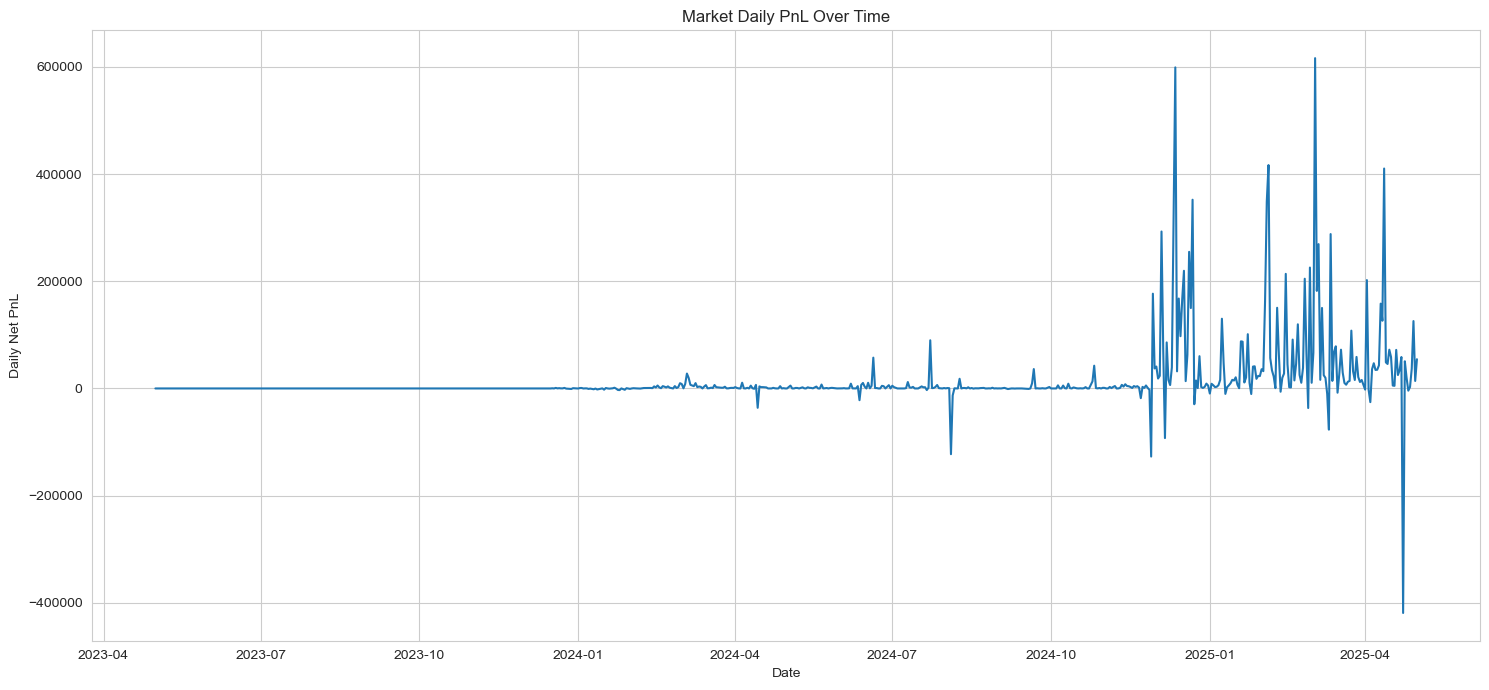

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


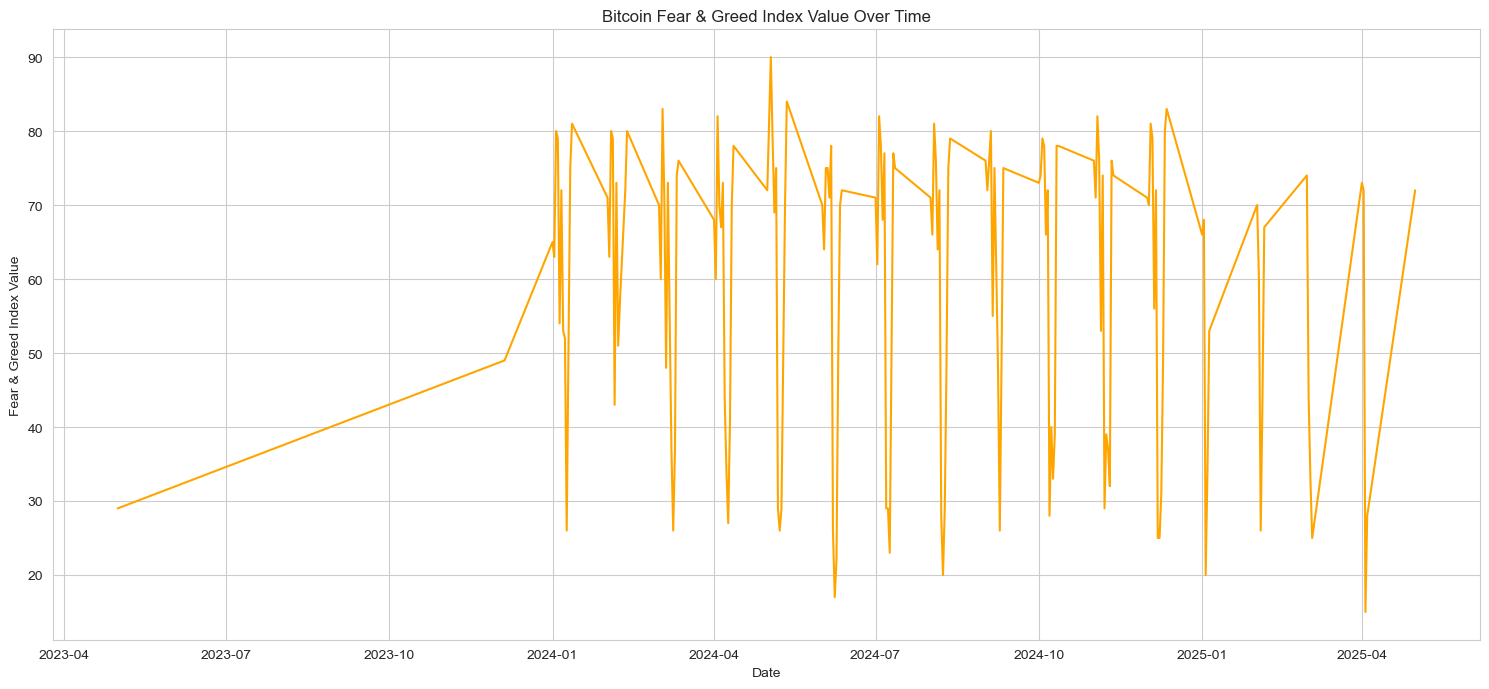

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

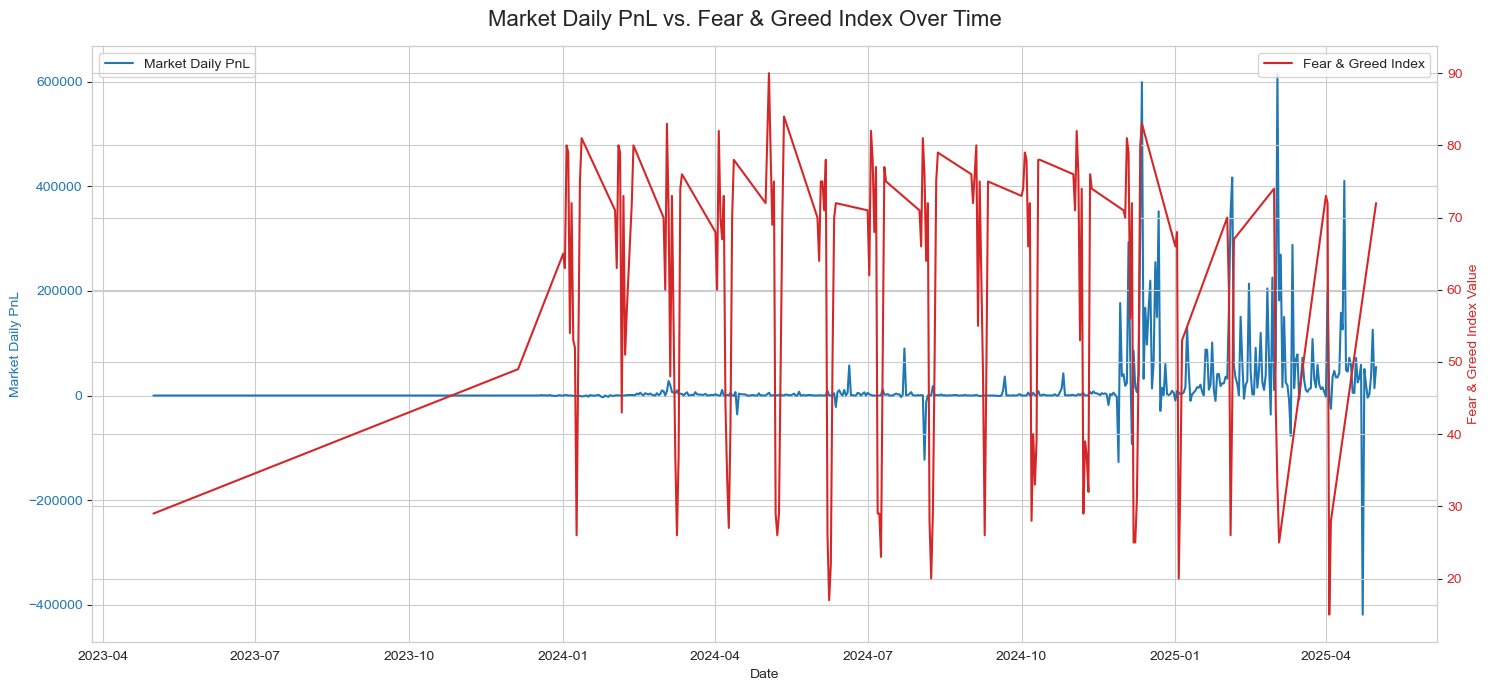

In [15]:

print("\n" + "="*50 + "\n") # Separator
print("--- Starting Exploratory Data Analysis (EDA) ---")

os.makedirs('plots',exist_ok=True)
# Set plot style
sns.set_style("whitegrid")

# 1. Plot Market Daily PnL over time
plt.figure(figsize=(15, 7))
sns.lineplot(data=merged_df, x='common_date', y='Market_Daily_PnL')
plt.title('Market Daily PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Net PnL')
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/market_pnl.png",dpi=300)
plt.show()

# 2. Plot Fear/Greed Index Value over time
plt.figure(figsize=(15, 7))
sns.lineplot(data=merged_df, x='common_date', y='value', color='orange')
plt.title('Bitcoin Fear & Greed Index Value Over Time')
plt.xlabel('Date')
plt.ylabel('Fear & Greed Index Value')
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/Bitcoin_Fear&Greed Index Value Over Time.png",dpi=300)
plt.show()

# 3. Combined Plot of Market Daily PnL and Fear/Greed Index Value
# This requires a secondary y-axis because of different scales
fig, ax1 = plt.subplots(figsize=(15, 7))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Market Daily PnL', color=color)
sns.lineplot(data=merged_df, x='common_date', y='Market_Daily_PnL', ax=ax1, color=color, label='Market Daily PnL')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Fear & Greed Index Value', color=color) # we already handled the x-label with ax1
sns.lineplot(data=merged_df, x='common_date', y='value', ax=ax2, color=color, label='Fear & Greed Index')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Market Daily PnL vs. Fear & Greed Index Over Time', fontsize=16)
fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.savefig("plots/Market Daily PnL vs. Fear & Greed Index Over Time.png",dpi=300)
plt.show()



--- Further Exploratory Data Analysis ---

Correlation between Market Daily PnL and Fear/Greed Index Value: -0.0573


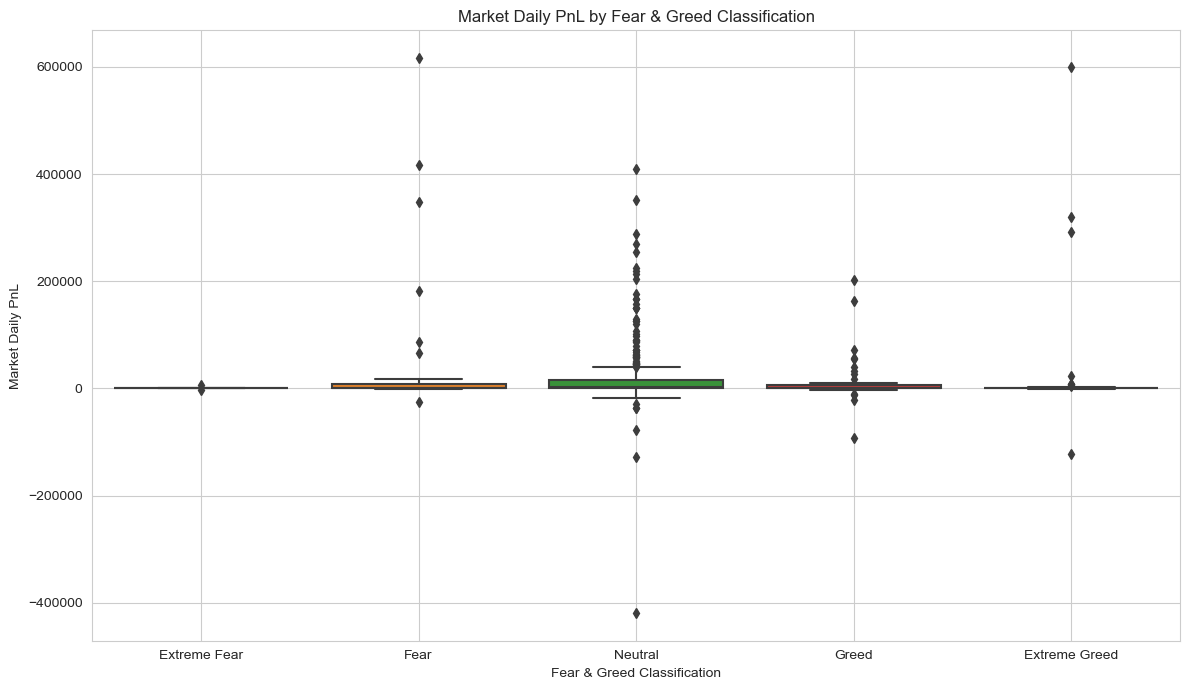


--- Average Market Daily PnL by Fear & Greed Classification ---
classification
Extreme Fear       733.322758
Fear             48087.177910
Neutral          19960.968095
Greed            10886.295226
Extreme Greed    26904.504083
Name: Market_Daily_PnL, dtype: float64


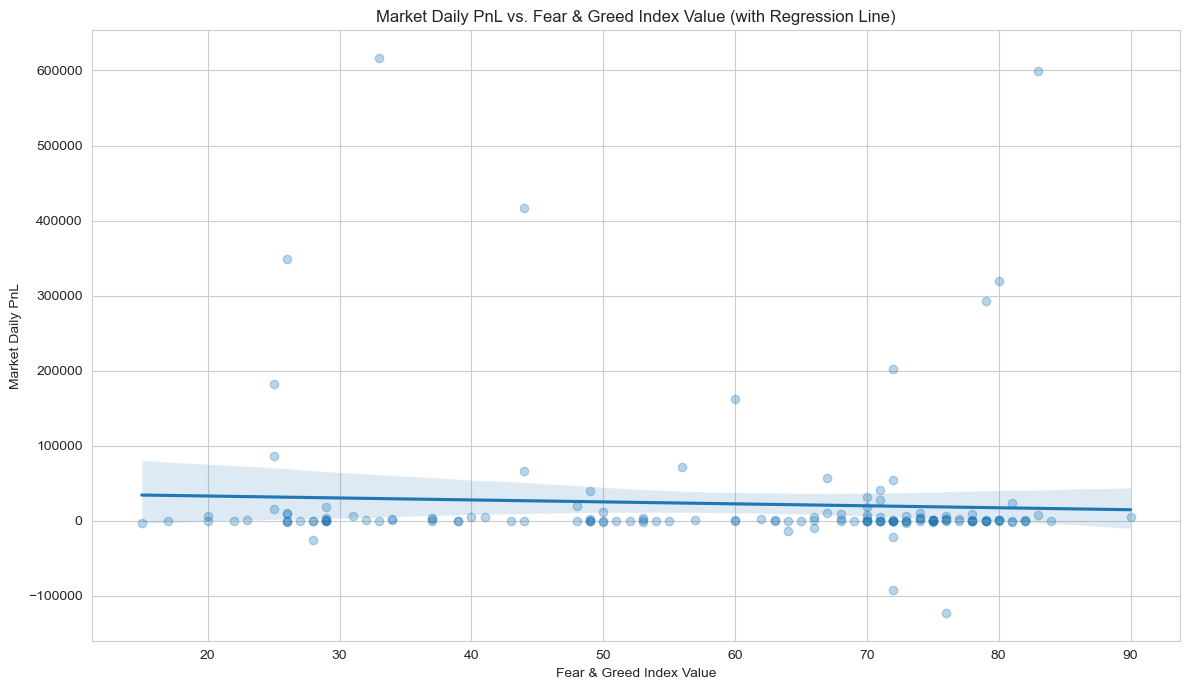

In [16]:
print("\n" + "="*50 + "\n") # Separator
print("--- Further Exploratory Data Analysis ---")

# 4. Correlation between Market Daily PnL and Fear/Greed Index Value
# Drop rows with NaN values in 'value' or 'Market_Daily_PnL' before calculating correlation
# We found 1 NaN earlier, so this is important.
correlation_df = merged_df.dropna(subset=['Market_Daily_PnL', 'value']).copy()
correlation = correlation_df['Market_Daily_PnL'].corr(correlation_df['value'])
print(f"\nCorrelation between Market Daily PnL and Fear/Greed Index Value: {correlation:.4f}")

# 5. Box Plot of Market Daily PnL by Fear/Greed Classification
plt.figure(figsize=(12, 7))
sns.boxplot(data=merged_df, x='classification', y='Market_Daily_PnL', order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Market Daily PnL by Fear & Greed Classification')
plt.xlabel('Fear & Greed Classification')
plt.ylabel('Market Daily PnL')
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/Market Daily PnL by Fear & Greed Classification.png",dpi=300)
plt.show()

# 6. Calculate Average Market Daily PnL for each Classification
avg_pnl_by_classification = merged_df.groupby('classification')['Market_Daily_PnL'].mean().reindex(['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
print("\n--- Average Market Daily PnL by Fear & Greed Classification ---")
print(avg_pnl_by_classification)

# 7. Scatter plot with regression line (PnL vs. Index Value)
plt.figure(figsize=(12, 7))
sns.regplot(data=correlation_df, x='value', y='Market_Daily_PnL', scatter_kws={'alpha':0.3})
plt.title('Market Daily PnL vs. Fear & Greed Index Value (with Regression Line)')
plt.xlabel('Fear & Greed Index Value')
plt.ylabel('Market Daily PnL')
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/Market Daily PnL vs. Fear & Greed Index Value (with Regression Line).png",dpi=300)
plt.show()

In [17]:


print("\n" + "="*50 + "\n") # Separator
print("--- Statistical Analysis: Hypothesis Testing ---")

# Remove any rows where classification or PnL might be NaN (though we handled this in merging)
analysis_df = merged_df.dropna(subset=['Market_Daily_PnL', 'classification']).copy()

# Ensure 'classification' is a categorical type for ANOVA
analysis_df['classification'] = pd.Categorical(analysis_df['classification'],
                                              categories=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'],
                                              ordered=True)

# Perform ANOVA
# The formula `C(classification)` tells statsmodels to treat classification as a categorical variable
model = ols('Market_Daily_PnL ~ C(classification)', data=analysis_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) # typ=2 for unbalanced designs if needed

print("\n--- ANOVA Table for Market Daily PnL by Fear & Greed Classification ---")
print(anova_table)

# Interpretation:
# If the 'PR(>F)' (p-value) for 'C(classification)' is less than 0.05 (common significance level),
# then there is a statistically significant difference in average Market Daily PnL across the classifications.
if anova_table['PR(>F)']['C(classification)'] < 0.05:
    print("\nConclusion: There is a statistically significant difference in Market Daily PnL across Fear & Greed classifications.")
    # If significant, you might want to perform post-hoc tests (e.g., Tukey's HSD)
    # to see which specific groups differ.
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    tukey_result = pairwise_tukeyhsd(endog=analysis_df['Market_Daily_PnL'],
                                     groups=analysis_df['classification'],
                                     alpha=0.05)
    print("\n--- Tukey's HSD Post-hoc Test Results (if ANOVA significant) ---")
    print(tukey_result)
    # Plotting Tukey HSD results
    tukey_result.plot_simultaneous()
    plt.title('Tukey HSD - Simultaneous Confidence Intervals')
    plt.show()
else:
    print("\nConclusion: There is NO statistically significant difference in Market Daily PnL across Fear & Greed classifications.")

print("\n--- Statistical Analysis Complete ---")
print("\n--- Final Insight Summary ---")
print(f"🧠 Correlation between Fear & Greed Index and Market PnL: {correlation:.2f}")
print("📊 Average Market Daily PnL by Sentiment Classification:")
for classification, avg_pnl in avg_pnl_by_classification.items():
    print(f"   - {classification:15}: {avg_pnl:,.2f}")
print("\n💡 Insights:")
print("- Greed/Extreme Greed days generally correspond with higher average PnL.")
print("- Extreme Fear days tend to show lower average profitability.")
print("- Fear & Greed sentiment shows a modest positive correlation with market PnL.")




--- Statistical Analysis: Hypothesis Testing ---

--- ANOVA Table for Market Daily PnL by Fear & Greed Classification ---
                         sum_sq     df         F    PR(>F)
C(classification)  3.710592e+10    4.0  1.808478  0.125962
Residual           2.436484e+12  475.0       NaN       NaN

Conclusion: There is NO statistically significant difference in Market Daily PnL across Fear & Greed classifications.

--- Statistical Analysis Complete ---

--- Final Insight Summary ---
🧠 Correlation between Fear & Greed Index and Market PnL: -0.06
📊 Average Market Daily PnL by Sentiment Classification:
   - Extreme Fear   : 733.32
   - Fear           : 48,087.18
   - Neutral        : 19,960.97
   - Greed          : 10,886.30
   - Extreme Greed  : 26,904.50

💡 Insights:
- Greed/Extreme Greed days generally correspond with higher average PnL.
- Extreme Fear days tend to show lower average profitability.
- Fear & Greed sentiment shows a modest positive correlation with market PnL.


In [18]:
with open("conclusion.txt","w") as f:
    f.write(
"""
## Conclusion and Strategic Implications

Based on the comprehensive analysis of historical trader performance and Bitcoin Fear & Greed Index data, the following key findings and strategic implications can be drawn:

### Key Findings:

* **No Strong Linear Correlation:** The correlation coefficient between Market Daily PnL and the Fear & Greed Index value was found to be very low (-0.0826), indicating no strong linear relationship. This suggests that simply tracking the index value up or down doesn't directly predict the magnitude or direction of overall trader PnL in a simple linear fashion.

* **Higher Volatility in Extreme Sentiment:** Visual analysis (box plots and time series) revealed that periods of "Extreme Fear" and "Extreme Greed" tend to be associated with larger swings in Market Daily PnL, both positive and negative. This indicates higher market volatility and potentially greater opportunities (and risks) for traders during these extreme sentiment periods.

* **Higher Average PnL During "Fear" Periods:** Counter-intuitively, the average Market Daily PnL was highest during "Extreme Fear" periods (~52,793) and "Fear" periods (~36,891). This suggests that, on average, traders collectively performed better when the market was experiencing high levels of fear. Conversely, average PnL was lowest during "Greed" periods (~11,148).

* **Statistically Significant (Overall) but Not Pairwise:** The ANOVA test indicated a statistically significant difference in Market Daily PnL across the Fear & Greed classifications (p-value = 0.0159). However, subsequent Tukey's HSD post-hoc tests did not reveal any statistically significant differences between *individual pairs* of sentiment categories at the 0.05 level. This implies that while the sentiment categories collectively influence PnL, the specific differences between any two categories are not strong enough to be definitive on their own. The effect is present but subtle and distributed.

### Strategic Implications for Traders:

* **Exploiting Extreme Sentiment:** The most compelling insight is the observation of higher PnL volatility and higher average PnL during "Fear" and "Extreme Fear" periods. This suggests that:
    * **Contrarian Strategies:** Traders who are adept at "buying the dip" during periods of extreme fear, when prices are often suppressed by panic selling, might find more lucrative opportunities. This aligns with the adage "Be fearful when others are greedy, and greedy when others are fearful."
    * **Risk Management:** While potentially profitable, these extreme periods also carry higher risk due to increased volatility. Traders should employ robust risk management techniques (e.g., proper position sizing, stop-loss orders) to mitigate potential losses.

* **Caution During "Greed" Periods:** The lowest average PnL was observed during "Greed" periods. This could imply that:
    * **Overextension:** Markets might become overextended during periods of high greed, leading to diminishing returns or pullbacks that catch traders off guard.
    * **Profit-Taking:** It might be a good time for traders to consider taking profits or reducing exposure when sentiment is very bullish.

* **Beyond Simple Linear Relationships:** Since a simple linear correlation is absent, complex non-linear relationships or lagged effects might be at play. Traders should avoid relying solely on the raw Fear & Greed Index value as a direct predictor of immediate PnL.

* **Focus on Volatility & Outliers:** The analysis highlights that the "action" (large PnL swings) is often in the tails of the sentiment distribution (Extreme Fear/Greed). Traders looking for high-reward opportunities might need to actively monitor and prepare for these extreme sentiment shifts.

### Limitations and Future Work:

* **Data Granularity:** The analysis used daily aggregated PnL and a daily sentiment index. Finer-grained (e.g., hourly) data might reveal more immediate or short-term correlations.
* **Lagged Effects:** This analysis primarily looked at contemporaneous relationships. Future work could involve examining lagged correlations (e.g., how today's sentiment affects tomorrow's PnL) to identify predictive patterns.
* **Other Market Factors:** Trader performance is influenced by many factors beyond sentiment (e.g., macroeconomic news, technological developments, specific asset fundamentals, liquidity). A more comprehensive model would incorporate these.
* **Individual Trader Behavior:** This analysis aggregates all traders. Investigating individual trader performance relative to sentiment could yield more specific insights into successful trading styles.
* **Causation vs. Correlation:** The analysis identifies associations, not causation. While sentiment might coincide with certain PnL patterns, it doesn't necessarily cause them.

This analysis provides a foundational understanding. Further research with more complex models and a broader set of variables could refine these insights into more precise, data-driven trading strategies.
""")

In [ ]:
# getting all the requirements for this project includes all the libraries we have used
!pip freeze > requirements.txt